In [2]:
# Example for LOPF (Linear Optimal Power Flow) and PF (non-linear Power Flow) 
# for network contingency analysis
# Example: SciGRID Network (https://docs.pypsa.org/latest/examples/scigrid-lopf-then-pf)
# import necessary libraries
import pypsa
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
# import functions from pypsa
from pypsa.common import annuity

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v1.0.5/examples/networks/scigrid-de/scigrid-de.nc.
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


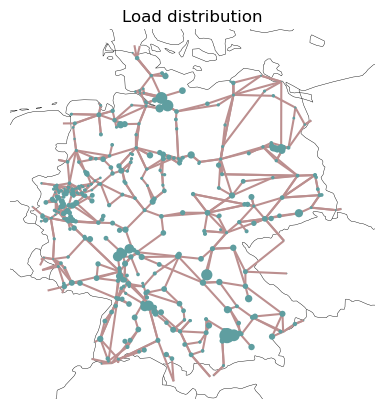

In [4]:
# load SciGRID Germany network example
n = pypsa.examples.scigrid_de()

fig, ax = plt.subplots(
    1,
    1,
    subplot_kw={"projection": ccrs.EqualEarth()},
)

load_distribution = n.loads_t.p_set.loc[n.snapshots[0]].groupby(n.loads.bus).sum()
n.plot(bus_size=load_distribution / 30000, ax=ax, title="Load distribution")
plt.show()

In [5]:
# print some information
print(n.generators.groupby("carrier")["p_nom"].sum().round(1))
print(n.storage_units.groupby("carrier")["p_nom"].sum().round(1))

carrier
Brown Coal       20879.5
Gas              23913.1
Geothermal          31.7
Hard Coal        25312.6
Multiple           152.7
Nuclear          12068.0
Oil               2710.2
Other             3027.8
Run of River      3999.1
Solar            37041.5
Storage Hydro     1445.0
Waste             1645.9
Wind Offshore     2973.5
Wind Onshore     37339.9
Name: p_nom, dtype: float64
carrier
Pumped Hydro    9179.5
Name: p_nom, dtype: float64


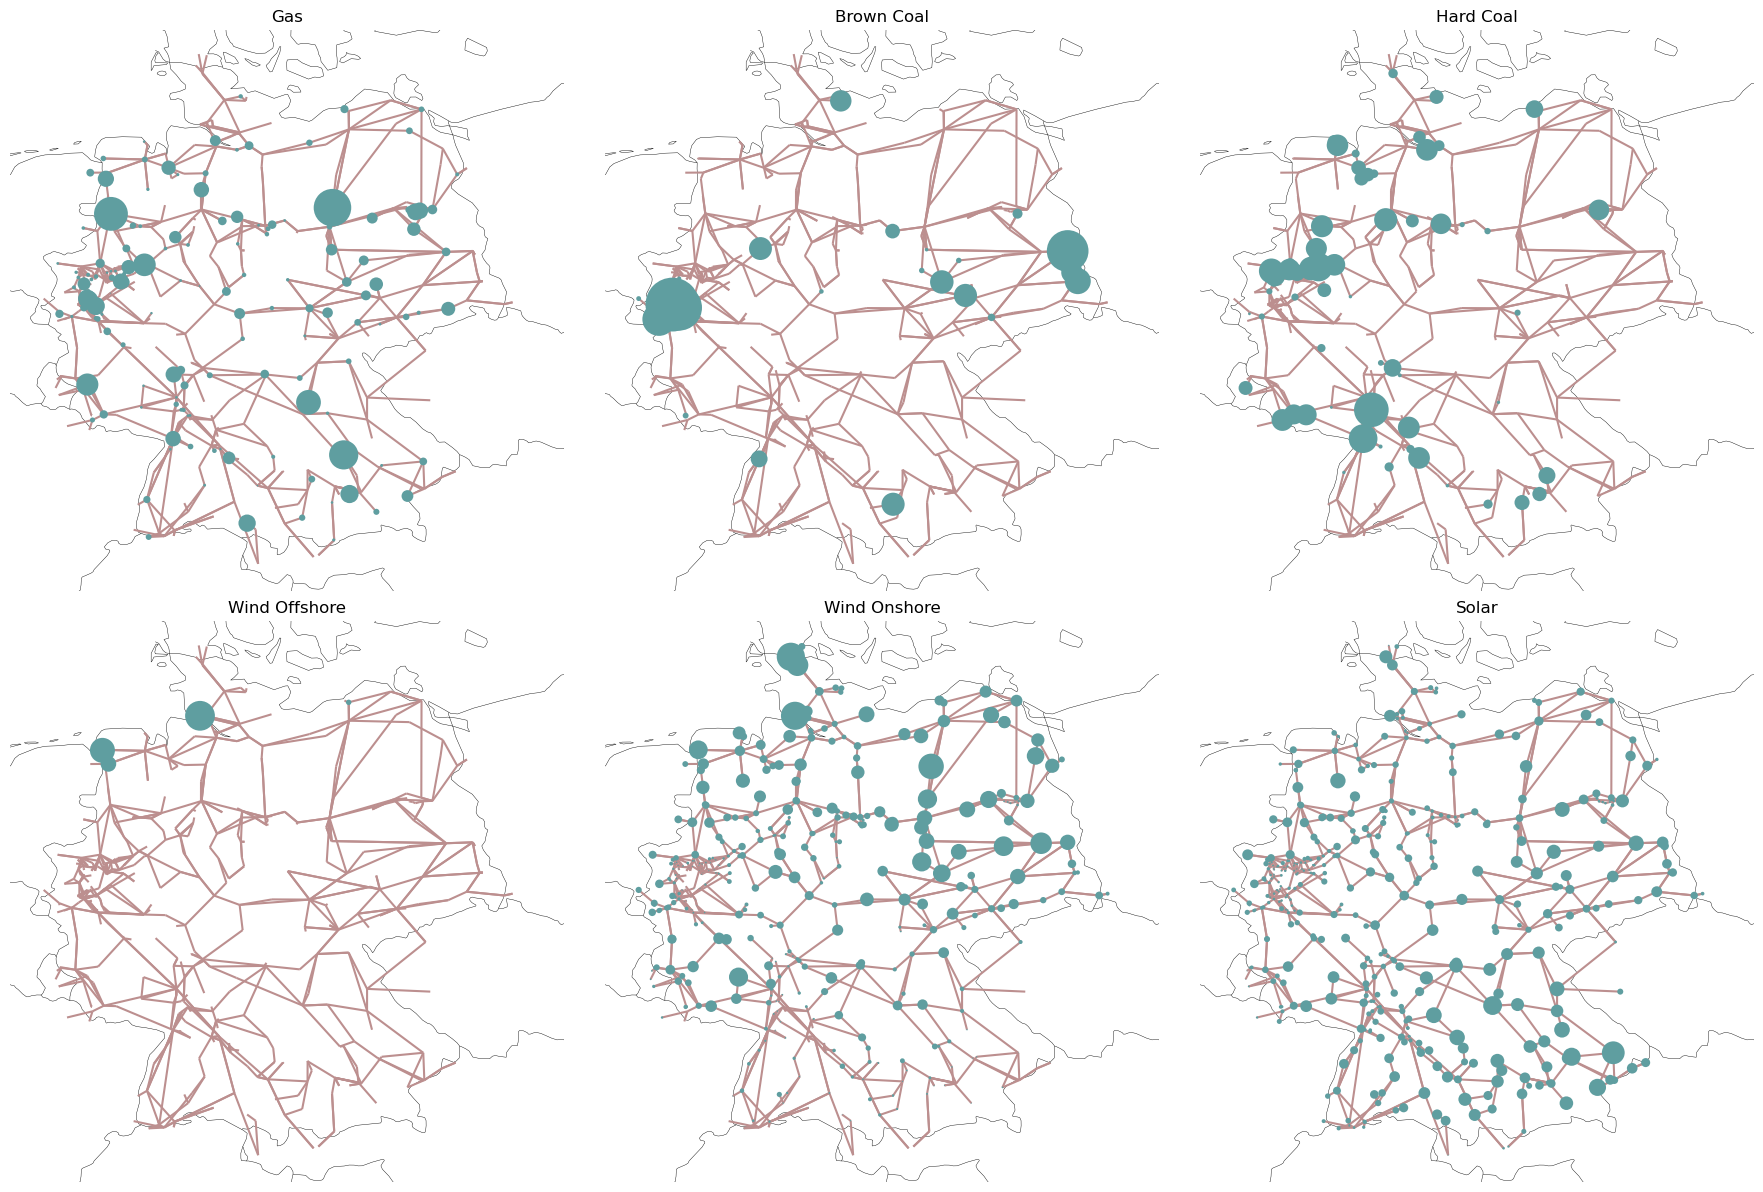

In [6]:
# plot generation capacity maps for different carriers/technologies
techs = ["Gas", "Brown Coal", "Hard Coal", "Wind Offshore", "Wind Onshore", "Solar"]

n_graphs = len(techs)
n_cols = 3
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1

fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols, subplot_kw={"projection": ccrs.EqualEarth()}
)
size = 6
fig.set_size_inches(size * n_cols, size * n_rows)

for i, tech in enumerate(techs):
    i_row = i // n_cols
    i_col = i % n_cols

    ax = axes[i_row, i_col]
    gens = n.generators[n.generators.carrier == tech]
    gen_distribution = (
        gens.groupby("bus").sum()["p_nom"].reindex(n.buses.index, fill_value=0)
    )
    n.plot(ax=ax, bus_size=gen_distribution / 20000)
    ax.set_title(tech)
fig.tight_layout()
plt.show()

In [7]:
# rolling horizon optimization
contingency_factor = 0.7
n.lines.s_max_pu = contingency_factor
n.lines.loc[["316", "527", "602"], "s_nom"] = 1715
n.optimize.optimize_with_rolling_horizon(horizon=4, overlap=0, log_to_console=False)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-01-01 00:00:00:2011-01-01 03:00:00] (1/6).
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writ

PyPSA Network 'SciGrid-DE'
--------------------------
Components:
 - Bus: 585
 - Carrier: 16
 - Generator: 1423
 - Line: 852
 - Load: 489
 - StorageUnit: 38
 - SubNetwork: 1
 - Transformer: 96
Snapshots: 24

Index(['Brown Coal', 'Gas', 'Hard Coal', 'Nuclear', 'Run of River', 'Solar',
       'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='carrier')


Text(0.5, 0, '')

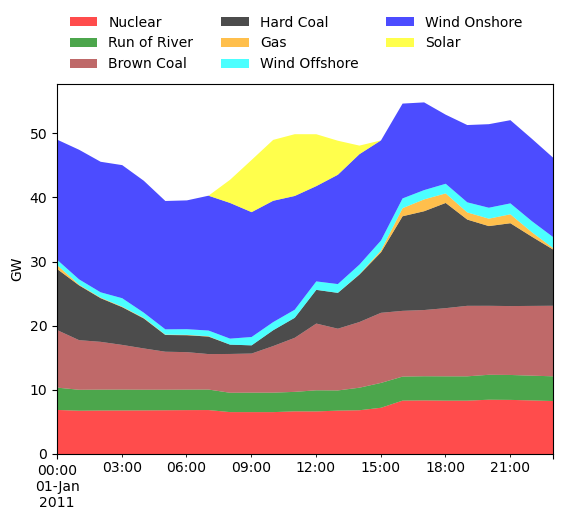

In [8]:
# plot dispatch time series
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T
to_drop = p_by_carrier.max()[p_by_carrier.max() < 1700].index
p_by_carrier.drop(to_drop, axis=1, inplace=True)
print(p_by_carrier.columns)

colors = {
    "Brown Coal": "brown",
    "Hard Coal": "k",
    "Nuclear": "r",
    "Run of River": "green",
    "Wind Onshore": "blue",
    "Solar": "yellow",
    "Wind Offshore": "cyan",
    "Waste": "orange",
    "Gas": "orange",
}
# reorder
cols = [
    "Nuclear",
    "Run of River",
    "Brown Coal",
    "Hard Coal",
    "Gas",
    "Wind Offshore",
    "Wind Onshore",
    "Solar",
]
p_by_carrier = p_by_carrier[cols]
c = [colors[col] for col in p_by_carrier.columns]
fig, ax = plt.subplots()
p_by_carrier.div(1e3).plot(kind="area", ax=ax, lw=0, color=c, alpha=0.7)
ax.legend(ncol=3, loc="upper left", bbox_to_anchor=(0, 1.02, 1, 0.2), frameon=False)
ax.set_ylabel("GW")
ax.set_xlabel("")

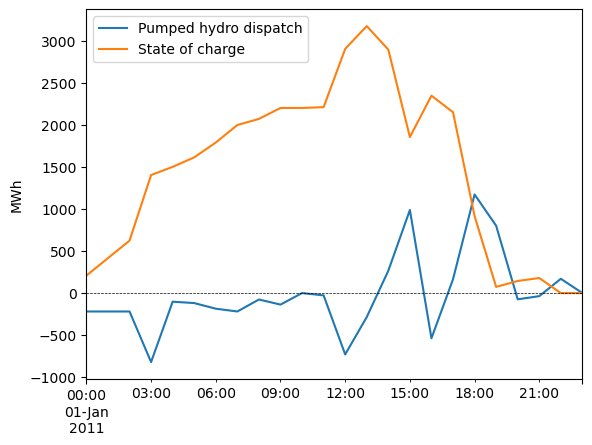

In [9]:
# plot storage time series
fig, ax = plt.subplots()

p_storage = n.storage_units_t.p.sum(axis=1)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax)
state_of_charge.plot(label="State of charge", ax=ax)

ax.axhline(0, color="k", lw=0.5, ls="--")
ax.legend()
ax.set_ylabel("MWh")
ax.set_xlabel("")

plt.show()

count    852.000000
mean      -0.003127
std        0.260218
min       -0.700000
25%       -0.127897
50%        0.003209
75%        0.121985
max        0.700000
dtype: float64


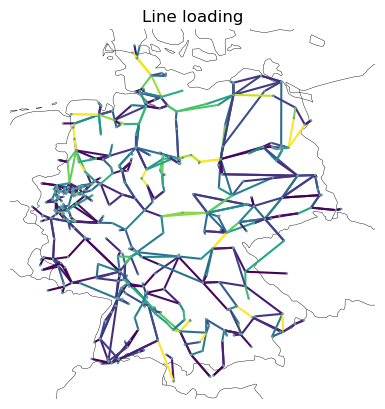

In [10]:
now = n.snapshots[4]
loading = n.lines_t.p0.loc[now] / n.lines.s_nom
print(loading.describe())
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()})
n.plot(
    ax=ax,
    line_color=loading.abs(),
    line_cmap="viridis",
    title="Line loading",
    bus_size=1e-3,
)
plt.show()


count    585.000000
mean      15.737598
std       10.941995
min      -10.397824
25%        6.992120
50%       15.841190
75%       25.048186
max       52.150120
Name: 2011-01-01 04:00:00, dtype: float64


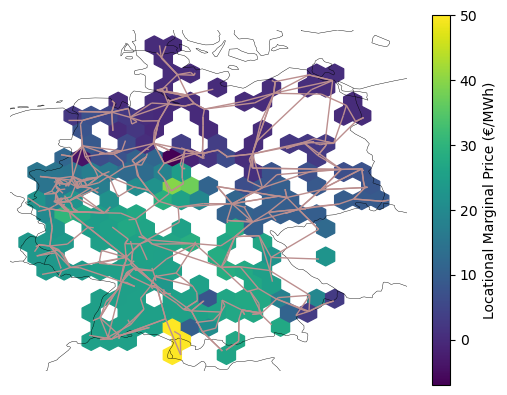

In [11]:
# Locational marginal prices
print(n.buses_t.marginal_price.loc[now].describe())
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    C=n.buses_t.marginal_price.loc[now],
    cmap="viridis",
    zorder=-1,
)
n.plot(ax=ax, line_width=1, bus_size=0)

cb = plt.colorbar(location="right")
cb.set_label("Locational Marginal Price (€/MWh)")
plt.show()

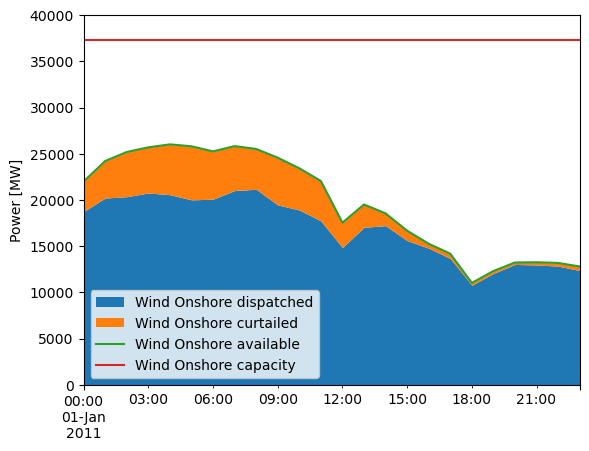

In [12]:
# Curtailment
carrier = "Wind Onshore"

capacity = n.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = n.generators_t.p_max_pu.multiply(n.generators["p_nom"])
p_available_by_carrier = p_available.T.groupby(n.generators.carrier).sum().T
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

p_df = pd.DataFrame(
    {
        carrier + " available": p_available_by_carrier[carrier],
        carrier + " dispatched": p_by_carrier[carrier],
        carrier + " curtailed": p_curtailed_by_carrier[carrier],
    }
)

p_df[carrier + " capacity"] = capacity

p_df.loc[p_df["Wind Onshore curtailed"] < 0, "Wind Onshore curtailed"] = 0

#plot
fig, ax = plt.subplots()
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, lw=0)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.set_ylim([0, 40_000])
ax.legend()
plt.show()

INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001EDC8BAD700> for snapshots DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)


{'n_iter': name                 0
snapshot              
2011-01-01 00:00:00  4
2011-01-01 01:00:00  4
2011-01-01 02:00:00  4
2011-01-01 03:00:00  4
2011-01-01 04:00:00  4
2011-01-01 05:00:00  4
2011-01-01 06:00:00  4
2011-01-01 07:00:00  4
2011-01-01 08:00:00  4
2011-01-01 09:00:00  4
2011-01-01 10:00:00  4
2011-01-01 11:00:00  4
2011-01-01 12:00:00  4
2011-01-01 13:00:00  4
2011-01-01 14:00:00  4
2011-01-01 15:00:00  4
2011-01-01 16:00:00  4
2011-01-01 17:00:00  4
2011-01-01 18:00:00  4
2011-01-01 19:00:00  4
2011-01-01 20:00:00  4
2011-01-01 21:00:00  4
2011-01-01 22:00:00  4
2011-01-01 23:00:00  4, 'error': name                            0
snapshot                         
2011-01-01 00:00:00  4.303203e-09
2011-01-01 01:00:00  3.846591e-09
2011-01-01 02:00:00  3.320302e-09
2011-01-01 03:00:00  2.325109e-09
2011-01-01 04:00:00  3.089994e-09
2011-01-01 05:00:00  2.941523e-09
2011-01-01 06:00:00  3.078604e-09
2011-01-01 07:00:00  3.055906e-09
2011-01-01 08:00:00  3.773934e-09
2011-01

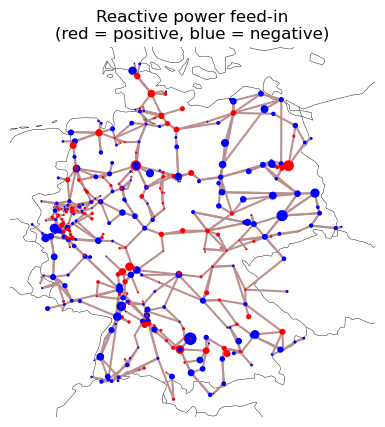

In [13]:
# non-linear Power Flow
n.optimize.fix_optimal_dispatch()

n.generators.control = "PV"

f = n.generators[n.generators.bus == "492"]
n.generators.loc[f.index, "control"] = "PQ"
info = n.pf()
print(info)
print((~info.converged).any().any())
print((n.lines_t.p0.loc[now] / n.lines.s_nom).describe())

df = n.lines.copy()

for b in ["bus0", "bus1"]:
    df = pd.merge(
        df, n.buses_t.v_ang.loc[[now]].T, how="left", left_on=b, right_index=True
    )

s = df[str(now) + "_x"] - df[str(now) + "_y"]

print((s * 180 / np.pi).describe())

# plot the reactive power
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()})

q = n.buses_t.q.loc[now]
bus_color = q.map(lambda x: "b" if x < 0 else "r")

n.plot(
    bus_size=q.abs() / 1e4,
    ax=ax,
    bus_color=bus_color,
    title="Reactive power feed-in\n(red = positive, blue = negative)",
)
plt.show()